# Oil availability prediction model

This model aims at using existing production and reserves data to anticipate oil availability and especially shortage of oil supply until 2100.

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
# import required classes
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# set_config(display='diagram')
warnings.filterwarnings('ignore')

# %matplotlib inline

## Exploring and cleaning dataset

In [2]:
class dataset:
    
    """
    Create a clean dataset out of bp stat review like format gathering file from `self.source` path

    
    Attributes:
    - df: the result dataframe used later in models
    - source: path to the data to be loaded
    
    Methods:
    - load_dataset
    - set_source
    - cleaning_bp_dataset
    
    """
    
    df= pd.DataFrame()
    source = 'data/bp_stats_review_2020_consolidated_dataset_panel_format.csv'
    
    def __init__(self):
        """
        load and clean default dataset: bp stat review 2020
        """
        self.load_dataset()
        self.cleaning_bp_dataset()
    
    def load_dataset(self):
        """
        load dataset to dataframe from the source path
        """
        self.df = pd.read_csv(self.source)
    
    def set_source(self, path):
        """
        change the source path for the dataset
        """
        self.source = path
        
    def cleaning_bp_dataset(self):
        """
        perform dataset cleaning on self.df
        """
        # converting production and consommation to volume per year in bbl
        self.df.loc[:,'oilcons_yearlybbl'] = self.df.oilcons_kbd.apply(lambda x: x*361/1000000)
        self.df.loc[:,'oilprod_yearlybbl'] = self.df.oilprod_kbd.apply(lambda x: x*361/1000000)
        # restraining dataset only to useful feature for oil assertion
        self.df = self.df[['Country', 'Year', 'pop', 'ISO3166_alpha3', 'Region',
       'SubRegion', 'OPEC', 'EU', 'OECD', 'CIS','oilprod_yearlybbl','oilcons_yearlybbl', 'oilreserves_bbl']]
        # remove all total counts from the data
        self.df = self.df[~self.df.Country.isin(['Total Africa',
       'Total Asia Pacific', 'Total CIS', 'Total Central America',
       'Total Eastern Africa', 'Total Europe', 'Total European Union',
       'Total Middle Africa', 'Total Middle East', 'Total Non-OECD',
       'Total North America', 'Total OECD', 'Total S. & Cent. America',
       'Total Western Africa', 'Total World'])]
        # fill the missing reserves by backfill method
        self.df.oilreserves_bbl = self.df.oilreserves_bbl.fillna(method='bfill')
        # calculating the cumulated production of oil per country
        self.df.loc[:,'cumulated_prod_bbl'] = self.df.groupby(['Country'])['oilprod_yearlybbl'].cumsum()
        # calculating a corrected reserve by country by removing the production which seems to have been eluded (ex. UAE)
        self.df['reserves_corr'] = self.df['oilreserves_bbl'] - self.df['cumulated_prod_bbl']
        self.df['reserves_corr'] = self.df['reserves_corr'].apply(lambda x:x if x>=0 else 0)
    

In [10]:
class reserves_model:
    
    """
    Create a model that makes prediction about oil reserves by country
    
    Attributes:
    
    - df:the historical data used for regression and fitting of the models
    - pred_end: the year until which to make the predictions
    - years_2100: the array of all years for which the prediction will be made
    - lasso: a linear regression model
    - elNet: a linear regression model
    - linreg: a linear regression model
    - svr: a support vector regression model with a polynomial 2 kernel
    - rbf: an rbf regression model
    - model: the chosen model (lasso after initial tests)
    - preds: a dictionnary where keys are the model type and values are the dataframes containing predictions associated to this model
    - models: the list of model types to run for making predictions (this gives all the keys in preds)
    - end_of_reserves: likely to be deleted - test to be done
    - total_prod_2020: the overall production of crude oil in 2020
    - production_proportions_2019: the proportion in 2019 that represents each supplier country of crude oil within the total production
    - eor: a dataframe to indicates information about the end of reserves for each country or the limit reached at the end of the max prediction year (pred_end)
    - world_limits: a dictionary of world reserves limit by model type
    - shortage_world_reserves = a series used to plot by year the countries which comes to an end to their reserves and the associated world crude oil reserves remaining that year
    - pred_reserves_end: the intermediate dataframe with the list of country and the year of the end for their reserves
    
    Methods:
    - reg_country
    - end_of_reserves
    - plot_reg
    - world_reserves
    - reserve_limit
    - share_prod
    - find_country_eor
    - plot_world_reserves_vs_country_shortage
    
    TODO: 
    - debug computation, all preds give same result and does not converge to 0 (is share prod applied?)
    """
    
    df = pd.DataFrame()
    pred_end = 2300
    years_2100 = ""
    lasso = make_pipeline(StandardScaler(),Lasso(tol = .0001, alpha = .01))
    elNet = make_pipeline(StandardScaler(), ElasticNet(l1_ratio=0.7))
    linreg = make_pipeline(StandardScaler(), LinearRegression())
    svr = make_pipeline(StandardScaler(),SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,coef0=1))
    rbf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf', C=100, gamma=0.1, epsilon=.1))
    model = lasso
    preds = dict()
    models = ['lasso','elasticnet','linearregression','svr', 'rbf']
    end_of_reserves = [] # could be deleted?? tbd
    total_prod_2020 = 0
    production_proportions_2019 = []
    eor = pd.DataFrame()
    world_limits = dict()
    shortage_world_reserves = pd.Series()
    pred_reserves_end = pd.DataFrame()
    
    def __init__(self, data):
        """
        set the dataset and fit the models
        """
        self.df = data.df
        self.years_2100 = np.arange(1965,self.pred_end + 1 ,1)
        for i in self.models:
            self.preds[i] = pd.DataFrame(self.years_2100, columns = ['Year'])
        # run over all models and all countries
        for i in self.df.Country.unique():
            for j in self.models:
                self.reg_country(country = i, model_name = j)
        # correcting predictions to avoid negative values
        for i in self.models:
            self.preds[i] = self.preds[i].applymap(lambda x:x if x >=0 else 0)
            # calculating at world level
        for i in self.models:
            self.preds[i]['World'] = self.preds[i][self.df.Country.unique()].sum(axis = 1)
            
        self.total_prod_2020 = self.df.query('Year == 2019').oilprod_yearlybbl.sum()
        
        production_proportions_2019 = []
        for country in self.df.Country.unique():
            prod = dict()
            prod['Country'] = country
            prod['Proportion'] = self.df.query('Country == @country & Year ==2019').oilprod_yearlybbl.sum()/self.total_prod_2020
            prod['Year'] = 2019
            production_proportions_2019.append(prod)
        self.production_proportions_2019 = pd.DataFrame(production_proportions_2019)
#         already choosing lasso as baseline model
        self.find_country_eor()
        self.end_of_reserves(model_name = 'lasso')
        
        for i in self.models:
            self.share_prod(i)
            self.preds[i]['World'] = self.preds[i][self.df.Country.unique()].sum(axis = 1)
        self.find_country_eor()
        self.world_limits = {'lasso': self.reserve_limit('World'), 'svr': self.reserve_limit('World', 'svr'), 'rbf': self.reserve_limit('World', 'rbf')} 
    
    # create funciton to perform regression on a country
    def reg_country(self, country, model_name = 'lasso', remove_outliers = False, truncated_2000 = False, max_truncated = True):
        """
        perform the regression for the crude oil reserves of a country given a model type.
        it also takes some arguments to control the hypothesis taken to filter out historical values to get a consistent trend for oil reserves predictions
        """
        df = self.df
        model = self.model
        dfc = df.query("Country == @country")
    #     temporary correction for south sudan data - positive regression
        if country == 'South Sudan':
            dfc = dfc.query('Year >= 2015')
            remove_outliers = False
            truncated_2000 = False
            max_truncated = False
        else:
            pass
        if max_truncated:
            start_year = df.query('Country == @country')[df.query('Country == @country').reserves_corr == df.query('Country == @country').reserves_corr.max()].Year.values[0]
            dfc = dfc.query('Year >= @start_year')
        else:
            pass
        if truncated_2000:
            dfc = dfc.query('Year >= 2000')
        else:
            pass
        if remove_outliers:
            dfc = dfc[(dfc['reserves_corr'] >= dfc['reserves_corr'].mean() - dfc['reserves_corr'].std()) & (dfc['reserves_corr'] <= dfc['reserves_corr'].mean() + dfc['reserves_corr'].std())]
        else:
            pass
        X_train = dfc.Year.values.reshape(-1,1)
        Y_train = dfc.reserves_corr.values
        X = df.loc[df['Country'] == country].Year.unique().reshape(-1,1)
        model.fit(X_train,Y_train)
        global years_2100
        df.loc[df['Country'] == country,model_name] = model.predict(X)
        self.preds[model_name][country] = model.predict(self.years_2100.reshape(-1,1))

        # for polynomial regression take the hypotesis that reserves never goes up after reaching 0
    def end_of_reserves(self, model_name = 'lasso'):
        '''
        compute the end of reserves by country
        '''
        end_of_reserves = []
        for c in self.df.Country.unique():
            end_reserve = dict()
            end_reserve['country'] = c
            end_reserve['min_res'] = self.preds[model_name][c].min()
            if end_reserve['min_res'] <= 0:
                end_reserve['end_year'] = self.preds[model_name][self.preds[model_name][c]<=0].Year.min()
            else:
                end_reserve['end_year'] = self.pred_end + 1
            end_reserve['min_res'] = self.preds[model_name][c].min()
            if end_reserve['min_res'] > 0:
                 end_reserve['min_res_year'] = self.pred_end + 1
            else:
                end_reserve['min_res_year'] = self.preds[model_name][self.preds[model_name][c] == self.preds[model_name][c].min()].Year.values[0]
            self.preds[model_name].loc[self.preds[model_name]['Year']>= end_reserve['end_year'],c] = 0
            self.preds[model_name].loc[self.preds[model_name]['Year']>= end_reserve['min_res_year'],c] = end_reserve['min_res']
            end_of_reserves.append(end_reserve)
        self.eor = pd.DataFrame(end_of_reserves)

    # create a plot of all regressions
    def plot_reg(self,country, model_name='lasso'):
        """
        plot the oil reserves prediction and historical data for a country and a model type
        """
        plt.title(f'{country}')
        data = self.df.groupby(['Country','Year']).sum().loc[country].reset_index()
        sns.lineplot(x = 'Year', y= 'reserves_corr', data = data);
    #     sns.lineplot(x = 'Year', y= model_name, data= data);
        plt.axhline(0, color = 'orange');
        sns.lineplot(x = 'Year', y= country, data = self.preds[model_name], color = 'green');
    #     sns.lineplot(x = 'Year', y= country, data = preds_svr);
        plt.show()

    def world_reserves(self, model_name= 'lasso'):
        """
        Plot the crude world oil reserve for a model type with the detail by country
        """
        sns.lineplot(x = 'Year', y = 'World', data = self.preds[model_name]);
        sns.lineplot(x = 'Year', y = 'oilcons_yearlybbl', data = self.df.groupby(['Year']).sum());
        plt.show()
        # other plot of the reserves by country
        plt.figure(figsize=(20,30));
        sns.lineplot(data = self.preds[model_name].set_index('Year'));
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
        plt.show()

    # year in which reserves will be consumed entirely
    def reserve_limit(self,country, model = 'lasso'):
        """
        Compute the year to which reserves come to an end for a country and a model type for the reserves predictions
        """
        return self.preds[model][self.preds[model][country]<=0].Year.min()

    def share_prod(self, model = 'lasso'):
        """
        function to redistribute consumption to remaining suppliers when the reserves of a country or more come to an end
        """
        # number of countries who still have predicted reserves in 2019 for the selected model (svr to test)
        nb_producers_2019 = self.eor.query('min_res_year > 2019').shape[0]
        add = 0
        # redistribute in the first year all the remaining reserves from country bending before 2019
        corr = 0
        corr_i = 0
        producers = self.eor.query('min_res_year > 2019').country.unique().tolist()
        for i in range(2020,self.pred_end + 1,1):
            if self.eor.query('min_res_year == @i').shape[0] > 0:
        #         remove these countries from the list
                nb_producers_2019 -= len(self.eor.query('min_res_year == @i').country.values)
                for j in self.eor.query('min_res_year == @i').country.values:
                    producers.remove(j)
          # total of oil production to reassign to remaining countries
                add = add + self.production_proportions_2019[self.production_proportions_2019['Country'].isin(self.eor.query('min_res_year == @i').country.values)].Proportion.sum()*self.total_prod_2020
           # new correction
                if nb_producers_2019 == 0:
                    continue
                corr_i = add / nb_producers_2019
         # add here the loop to change all preds in df or add a correction or copy existing value to uncorrected
            self.preds[model].loc[self.preds[model]['Year'] == i,producers] = self.preds[model].loc[self.preds[model]['Year'] == i,producers].applymap(lambda x: x - corr)
            self.preds[model].loc[self.preds[model]['Year'] == i,producers] = self.preds[model].loc[self.preds[model]['Year'] == i,producers].applymap(lambda x:x if x>=0 else 0)
            corr += corr_i

    def find_country_eor(self, model_name = 'lasso'):
        """
        determining end of reserves by country for the predictions
        """
        pred = self.preds[model_name]
        pred_reserves_end = pred.set_index('Year').idxmin().reset_index()
        pred_reserves_end.columns =['Country','Year']
        self.pred_reserves_end = pred_reserves_end
        # recreate series of point corrresponding to the world reserve at the moment a country comes out of reserve
        self.shortage_world_reserves = pred_reserves_end.Year.apply(lambda x: pred[pred['Year'] == x].World.values[0])
    
    def plot_world_reserves_vs_country_shortage(self, model_name = 'lasso'):
        """
        plot the world reserves prediction for a model type with a point on the curve for each country where their reserves ends
        """
        plt.figure(figsize = (15,30))
        sns.lineplot(x = 'Year', y='World', data = self.preds[model_name]);
        plt.scatter(x = self.pred_reserves_end.Year, y= self.shortage_world_reserves, color = 'red');
        # plot country name next to each point
        for i, txt in enumerate(self.pred_reserves_end.Country):
            plt.annotate(txt, (self.pred_reserves_end.Year[i]+1, self.shortage_world_reserves[i]+1));
        plt.hlines(xmin = 1990, xmax = self.pred_end + 1 , y=0, color = 'red');
        plt.show()

In [4]:
class price_model:
    """
    Create a price model to predict crude oil prices based on a trendline out of historical data and a price correction at each period when a country reserves come to an end.
    The oil correction factor is based on an historical correlationin 1980's Iran production fall with an oil price increase.
    
    Attributes:
    - pr: historical crude oil prices dataframe
    - df: crude oil reserves data
    - drop: dataframe of production drops around country reserves end
    - pr_increase = daatframe with price increase predicted for the associated production drop
    - dr: dataframe with the synthesis of drop and price_increase
    - pr_reg: price regression model to fit for correction based on 1980's Iran production drop price impact
    - price: historical crude oil prices dataframe
    - pipe: model for baseline regression of the crude oil price historical trend
    - shortage_dates: series of the year when shortage occur (reserves of a country come to an end)
    - pred: oil reserves predictions for the retained lasso model type
    - years_2100: the array of years on which to make the predictions
    - pred_end: the max year until the preditcions are made
    
    Methods:
    - plot_price_historics
    - plot_price_vs_prod_change
    - price_correction
    - baseline_reg
    - plot_baseline
    - shortage_impact
    - predict_price
    - plot_price_preds
    
    """
    
    pr = pd.read_csv('data/bp_stats_review_2020_all_Oil_Crude_prices_since_1861.csv')
    df = pd.DataFrame()
    drop = pd.DataFrame()
    pr_increase = pd.DataFrame()
    dr = pd.DataFrame()
    pr_reg = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,coef0=1)
    price = pd.DataFrame()
    pipe = make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, gamma='auto'))
    shortage_dates = pd.Series()
    pred = pd.DataFrame()
    years_2100 = ""
    pred_end = 2300
    prices_pred = pd.DataFrame()
    
    def __init__(self, reserves_data, reserves_preds):
        """
        load data and fit the price model
        """
        self.years_2100 = np.arange(1965,self.pred_end + 1 ,1)
        self.df = reserves_data.df
        # correction shape -  function calculates the impact of the price increase function of the distance to the shortage in year
        self.drop = self.df[(self.df['Country'] == 'Iran') & (self.df['Year']>=1978) & (self.df['Year']<= 1982)].set_index('Year').oilprod_yearlybbl
        self.pr_increase = self.pr[(self.pr['Year']>=1978) & (self.pr['Year']<=1982)]['$ money of the day']
        self.dr.loc[:,'year']= self.drop.index
        self.dr.loc[:,'production']= self.drop.values
        self.dr.loc[:,'price'] = self.pr_increase.values
        self.dr.loc[self.dr['year']>self.dr.year.min(),'production_change'] = self.dr[self.dr['year']>self.dr.year.min()].year.apply(lambda x : (self.dr[self.dr['year'] == (x)].production.values[0] - self.dr[self.dr['year'] == x-1].production.values[0]))
        self.dr.loc[self.dr['year']>self.dr.year.min(),'price_change'] = self.dr[self.dr['year']>self.dr.year.min()].year.apply(lambda x : (self.dr[self.dr['year'] == (x)].price.values[0] - self.dr[self.dr['year'] == x-1].price.values[0]))
        self.dr.loc[:,'price_on_prod'] = self.dr['price_change']/(-1*self.dr['production_change'])
        self.pr_reg.fit(np.array(self.dr['production_change'].dropna()).reshape(-1,1),self.dr['price_change'].dropna())      
        self.price = self.pr[self.pr['Year']>=1960]
        self.baseline_reg()
        self.shortage_dates = reserves_preds.preds['lasso'].set_index('Year').idxmin()
        self.pred = reserves_preds.preds['lasso']
        self.prices_pred = pd.DataFrame([self.years_2100,self.predict_price(self.years_2100)]).T
        self.prices_pred.columns = ['year','price']
        
    def plot_price_historics(self):
        """
        plot the history of crude oil prices
        """
        # loading and plotting historical price data
        fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (15,25))
        sns.lineplot(x = 'Year', y = '$ 2019', data = self.pr, ax = ax1);
        sns.lineplot(x = 'Year', y = '$ money of the day', data = self.pr, color = 'orange', ax = ax1);
        for i in ['Iran']:
            sns.lineplot(data = self.df.query('Country == @i'), x = 'Year', y= 'oilprod_yearlybbl', ax = ax2, label = i);
        ax1.vlines(x = 1978, ymin = 0, ymax = 125, color = 'green')
        ax1.vlines(x = 1980, ymin = 0, ymax = 125, color = 'red')
        ax1.vlines(x = 1985, ymin = 0, ymax = 125, color = 'green')
        # ax1.vlines(x = 1986, ymin = 0, ymax = 125, color = 'red')
        ax2.vlines(x = 1978, ymin = 0, ymax = 5, color = 'green')
        ax2.vlines(x = 1980, ymin = 0, ymax = 5, color = 'red')
        ax2.vlines(x = 1985, ymin = 0, ymax = 5, color = 'green')
        # ax2.vlines(x = 1986, ymin = 0, ymax = 5, color = 'red')
        plt.xlim(1965,2020);

    
    def plot_price_vs_prod_change(self):
        """
        plot the defined model for production impact on price
        """
        sns.lineplot(x = 'production_change', y = 'price_change', data = self.dr);
        plt.scatter(x = np.arange(-1,0.5,.1),y = self.pr_reg.predict(np.arange(-1,0.5,.1).reshape(-1, 1)), color = 'orange');
        plt.show()

    def price_correction(self, prod):
        """
        compute correction of oil price for a given production drop based on fitted model
        """
        corr = self.pr_reg.predict(prod.reshape(-1,1))
        return corr

    def baseline_reg(self):
        """
        Fit price baseline
        """
        X = self.price['Year'].values.reshape(-1,1)
        y = self.price['$ money of the day'].values
        self.pipe.fit(X, y)
    
    def plot_baseline(self):
        """
        plot curde oil price prediction baseline from historical data trend
        """
        future = np.array(list(range(2019,2100,1))).reshape(-1, 1)
        lw = 2
        X = self.price['Year'].values.reshape(-1,1)
        y = self.price['$ money of the day'].values
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
        axes.plot(X, self.pipe.predict(X), color='blue', lw=lw,
                      label='{} model'.format('Polynomial'))
        axes.scatter(X[self.pipe[1].support_], y[self.pipe[1].support_], facecolor="none",
                         edgecolor='blue', s=50,
                         label='{} support vectors'.format('Polynomial'))
        axes.scatter(X[np.setdiff1d(np.arange(len(X)), self.pipe[1].support_)],
                         y[np.setdiff1d(np.arange(len(X)), self.pipe[1].support_)],
                         facecolor="none", edgecolor="k", s=50,
                         label='other training data')
        sns.lineplot(x = future.reshape(1, -1)[0] , y = self.pipe.predict(future).reshape(1, -1)[0], alpha = .5, dashes=[(2, 2)], style = True, color = 'orange')
        axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=True, shadow=True)
        fig.text(0.5, 0.04, 'data', ha='center', va='center')
        fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
        fig.suptitle("Support Vector Regression", fontsize=14)
        plt.show()
        

    # we decide to impact shortage overs 5 years as Iran crisis and it seems consistent. year 1 to 3 we consider the drop in production, while year 4 and 5 are equal in drop to 1 and 2 - logistic recovery time rest is 0 price impact
    def shortage_impact(self, Country):
        """
        intermediate funciton to compute the cumulated price impact for all shortage and each year
        """
        country = Country
        shortage_year = self.shortage_dates.loc[country] 
        if shortage_year>2020:
            rg = 3
            hist = self.pred[['Year',country]]
    #         hist = pred[(pred['Year'] >= shortage_year - rg) & (pred['Year'] <= shortage_year + rg)][['Year',country]]
            hist.loc[:,'production_drop'] = hist[(hist['Year'] >= shortage_year - rg+1) & (hist['Year'] <= shortage_year)].Year.apply(lambda x:hist.loc[hist['Year'] == x][country].values[0] - hist.loc[hist['Year'] == x-1][country].values[0])
            hist.loc[:,'production_drop_cum'] = hist.production_drop.cumsum()
            hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'price_change'] = self.price_correction(hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'production_drop_cum'].values)
            hist.loc[(hist['Year']>shortage_year) & (hist['Year']<shortage_year+rg),'price_change'] = hist[(hist['Year']>shortage_year) & (hist['Year']<shortage_year+rg)].Year.apply(lambda x: hist[hist['Year'] == shortage_year - (hist.loc[hist['Year'] == x,'Year'].values[0] - shortage_year)]['price_change'].values[0])
    #         hist.loc[(hist['Year']>shortage_year + rg) & (hist['Year']<shortage_year - rg)] = 0
            hist = hist.fillna(0)
    #         correction = hist.price_change.values
        else:
            hist = self.pred[['Year',country]]
            hist.loc[:,'price_change'] = 0
        return hist.price_change

    def predict_price(self, years):
        """
        make the complete prediction associated baseline and corrections from shortage occurence when country reserves end
        """
        base_price = self.pipe.predict(years.reshape(-1, 1))
        price_corrections = np.zeros(len(years))
        for c in self.df.Country.unique():
            price_corrections += self.shortage_impact(c)
        final_price = base_price + price_corrections
        return final_price

    def plot_price_preds(self, xmin = 2020, xmax = 2300, ymin = 0, ymax = 800):
        """
        plot the final predictions for crude oil price
        """
        sns.lineplot(x = self.years_2100, y = self.predict_price(self.years_2100));
        plt.ylim(ymin,ymax);
        plt.xlim(xmin,xmax);
        plt.xlabel('year');
        plt.ylabel('crude oil price');
        plt.title('Crude oil price predictions');
        plt.show()

In [5]:
dt = dataset()

In [11]:
re = reserves_model(dt)

In [12]:
pr = price_model(dt,re)

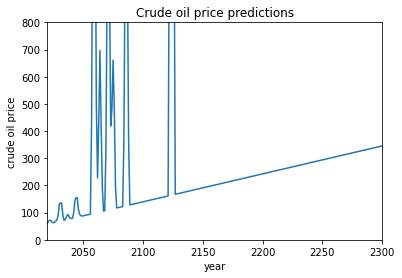

In [13]:
pr.plot_price_preds()

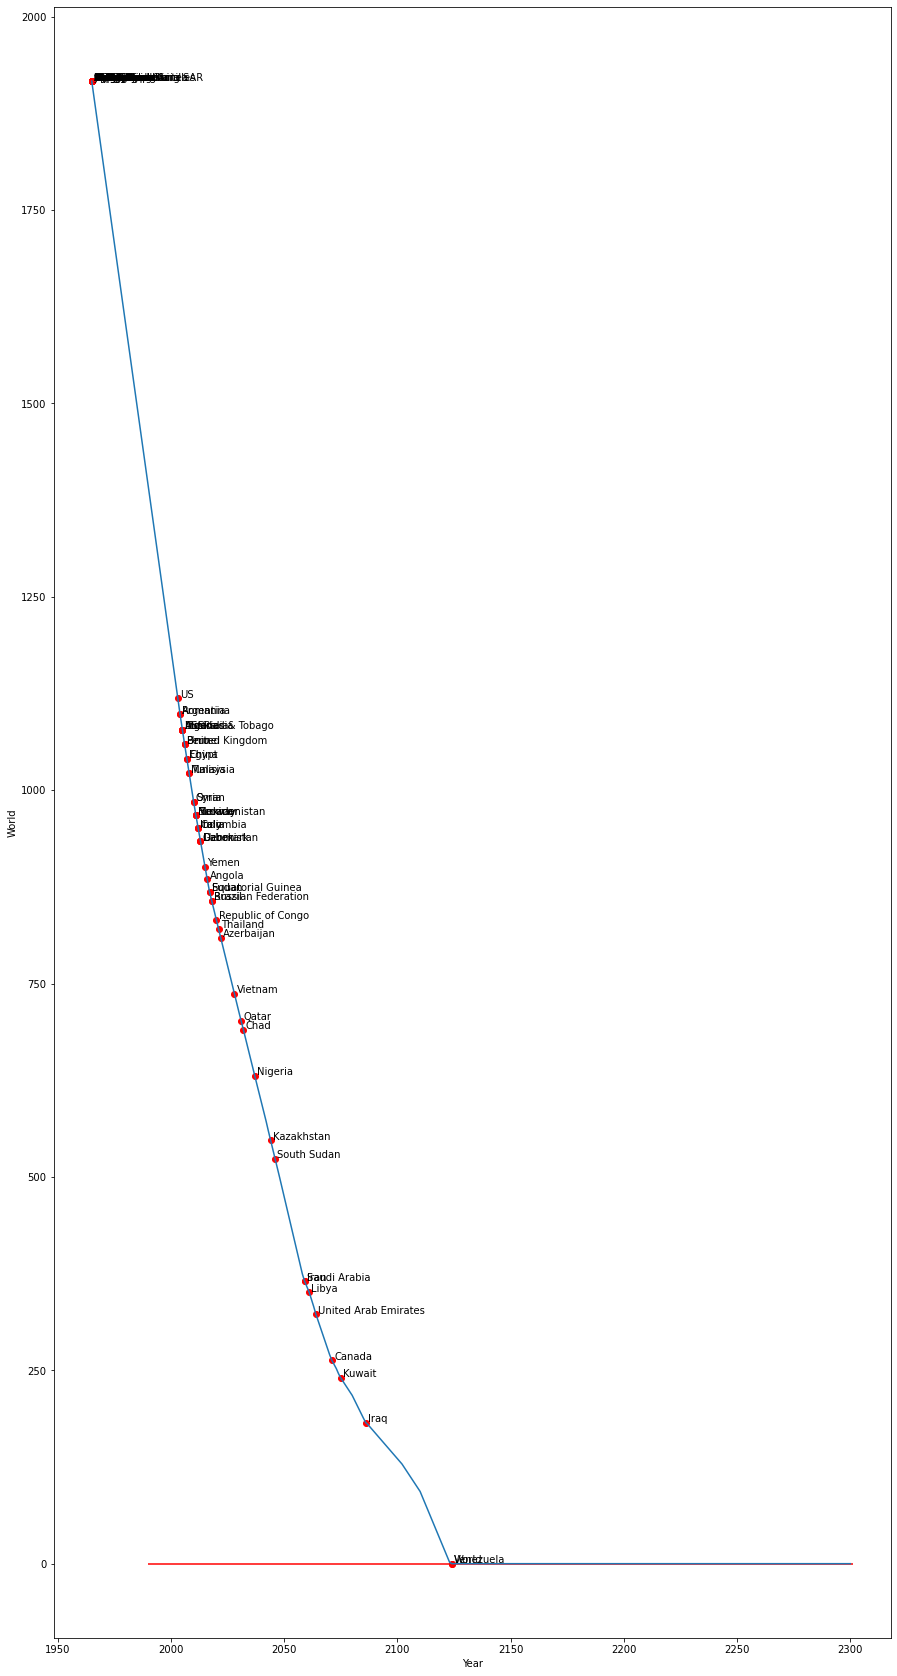

In [14]:
re.plot_world_reserves_vs_country_shortage()